In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

/opt/anaconda/envs/juplab_hk_torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [4]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [5]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [6]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

# Network parameters

In [7]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [8]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [9]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [10]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [11]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: 0.36468 | train_rmsle: 0.62777 | train_mae: 0.88251 | train_rmse: 1.17333 | train_mse: 1.37671 | valid_rmsle: 0.63301 | valid_mae: 0.89826 | valid_rmse: 1.21957 | valid_mse: 1.48736 |  0:00:00s
epoch 1  | loss: 0.13472 | train_rmsle: 0.54206 | train_mae: 0.70511 | train_rmse: 0.8231  | train_mse: 0.6775  | valid_rmsle: 0.53616 | valid_mae: 0.69109 | valid_rmse: 0.80668 | valid_mse: 0.65073 |  0:00:01s
epoch 2  | loss: 0.1233  | train_rmsle: 0.37803 | train_mae: 0.43987 | train_rmse: 0.51465 | train_mse: 0.26486 | valid_rmsle: 0.37507 | valid_mae: 0.43335 | valid_rmse: 0.5084  | valid_mse: 0.25847 |  0:00:02s
epoch 3  | loss: 0.11637 | train_rmsle: 0.31145 | train_mae: 0.33779 | train_rmse: 0.42857 | train_mse: 0.18367 | valid_rmsle: 0.30771 | valid_mae: 0.33166 | valid_rmse: 0.41226 | valid_mse: 0.16996 |  0:00:02s
epoch 4  | loss: 0.11149 | train_rmsle: 0.33816 | train_mae: 0.35563 | train_rmse: 0.48601 | train_mse: 0.23621 | valid_rmsle: 0.33377 | valid_mae: 0.34895 

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [12]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")

BEST VALID SCORE FOR census-income : 0.09468524153640476
FINAL TEST SCORE FOR census-income : 0.09864060683738828


# Save model and load

In [13]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [14]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [15]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_mse}")

FINAL TEST SCORE FOR census-income : 0.09864060683738828


In [16]:
assert(test_score == loaded_test_mse)

# Global explainability : feat importance summing to 1

In [17]:
clf.feature_importances_

array([9.84796168e-02, 0.00000000e+00, 0.00000000e+00, 4.04798028e-05,
       1.37901907e-01, 3.17770389e-01, 1.11752306e-06, 4.70624950e-03,
       1.23991124e-01, 4.22501498e-02, 1.22739909e-01, 6.15518263e-02,
       9.05641116e-02, 3.11911392e-06])

# Local explainability and masks

In [18]:
explain_matrix, masks = clf.explain(X_test)

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

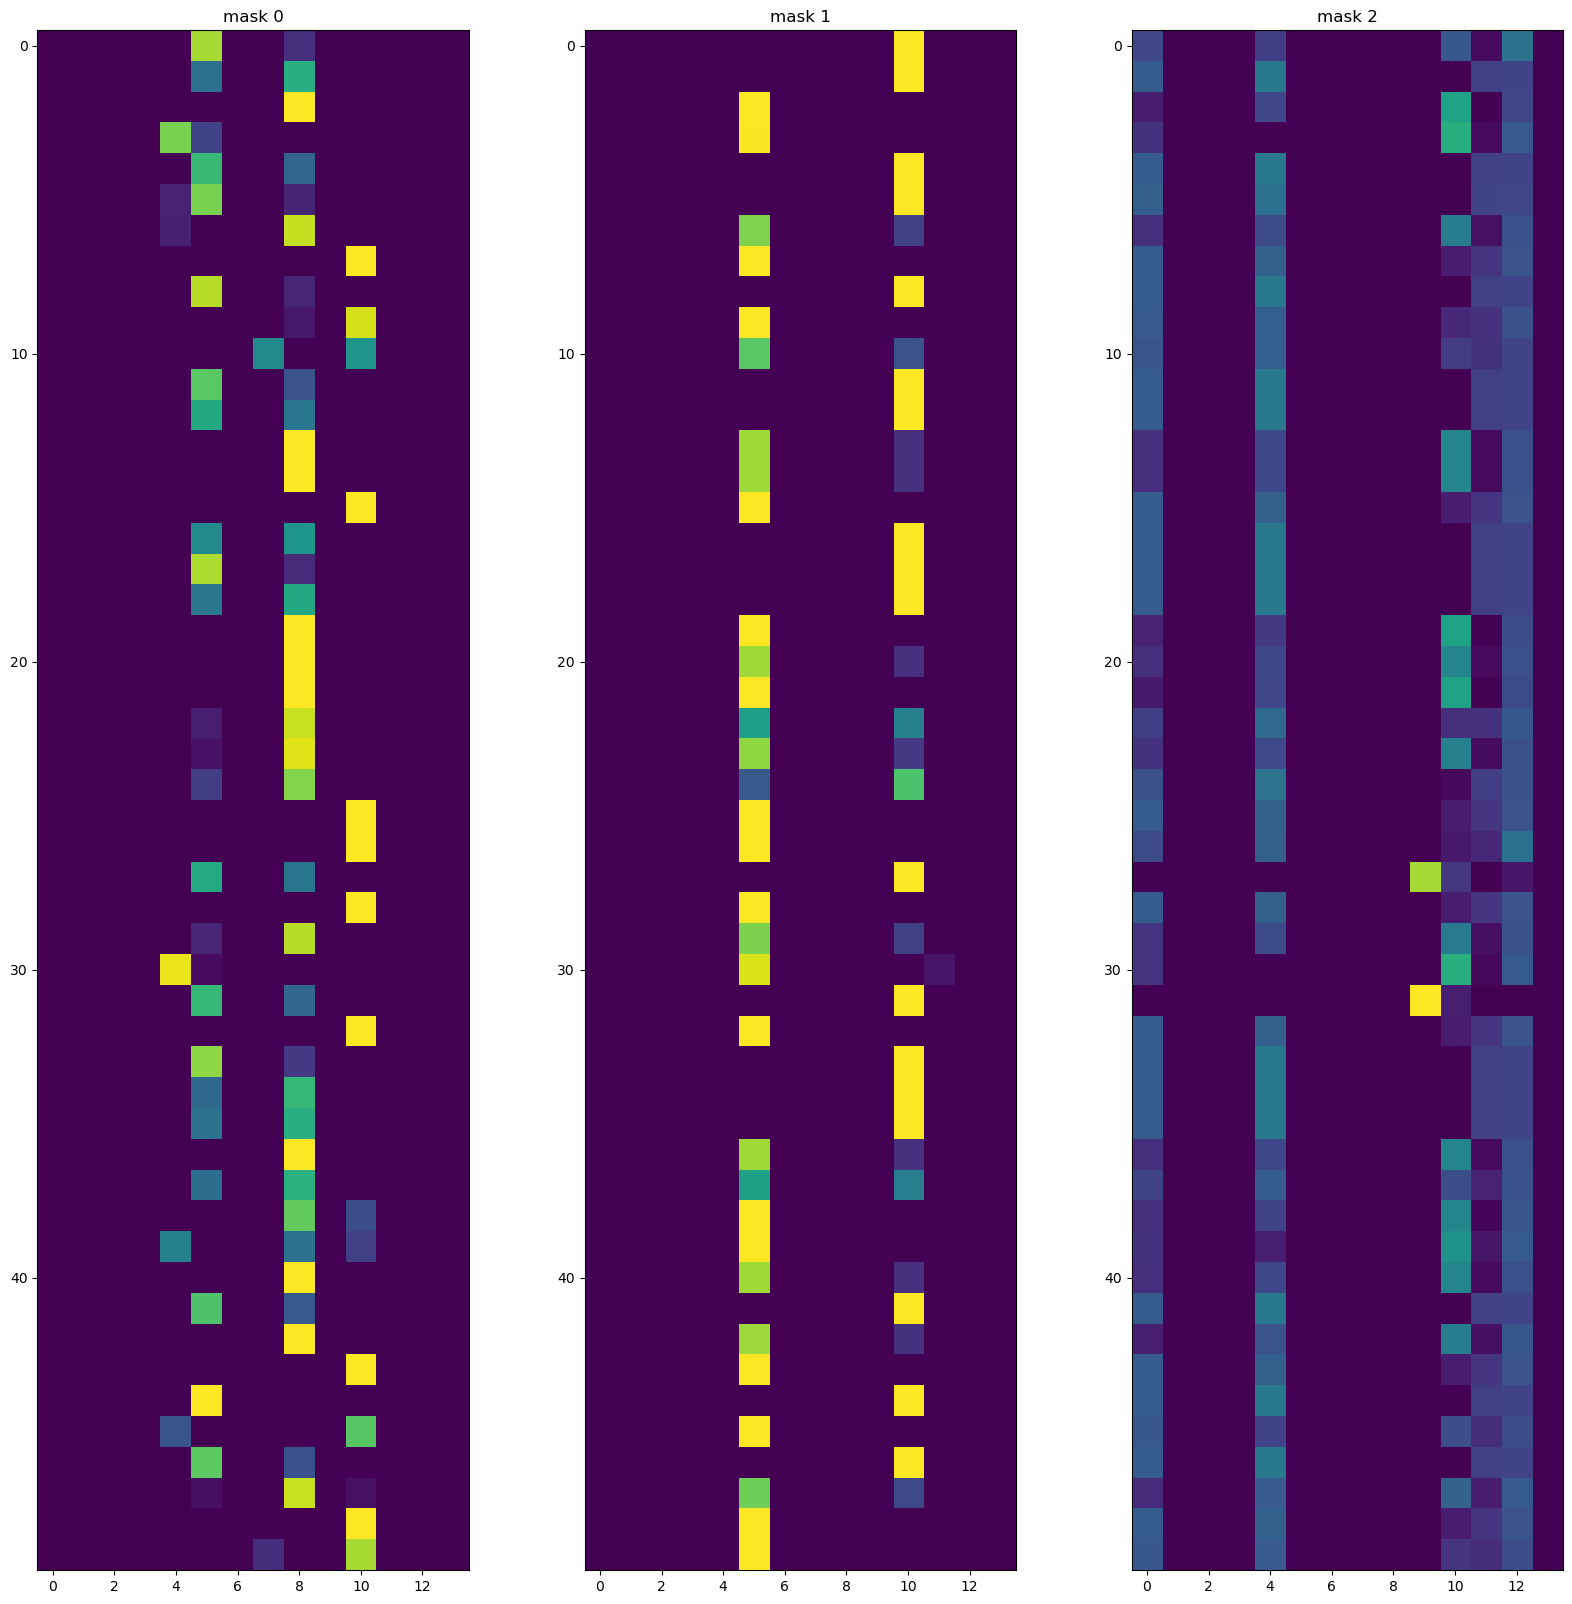

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [21]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.46992
[10]	validation_0-rmse:0.33056


/opt/anaconda/envs/juplab_hk_torch/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.30274
[30]	validation_0-rmse:0.29676
[40]	validation_0-rmse:0.29514
[50]	validation_0-rmse:0.29520
[60]	validation_0-rmse:0.29497
[70]	validation_0-rmse:0.29518
[80]	validation_0-rmse:0.29521
[90]	validation_0-rmse:0.29574
[100]	validation_0-rmse:0.29599
[101]	validation_0-rmse:0.29598


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

In [22]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)

0.08693414488964239
0.09148941118733249
